In [1]:
import math
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

!nvidia-smi

Fri Jun 16 09:30:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:15:00.0 Off |                    0 |
| N/A   26C    P0    39W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Dispositivo onde tensores serão criados, armazenados e processados
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Randon Seed fixa para resultados reprodutíveis
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

cuda:0


## Data Loader

In [3]:
class WellLoader(Dataset):
    
    def __init__(self, 
                 path, 
                 wells, 
                 var_in, 
                 var_out,
                 normalizing_percentile=90.0,
                 normalizing_split=0.2,
                 normalizer=RobustScaler,
                 max_sequence=16, 
                 step=1):
        
        self.path = path
        with open(self.path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())
        self.wells = wells
        self.var_in = var_in
        self.var_out = var_out
        self.normalizing_percentile=normalizing_percentile
        self.normalizing_split = normalizing_split
        self.normalizer = normalizer
        self.max_sequence = max_sequence
        self.step = step
        self.batches_X = None
        self.batches_Y = None
        self.outputs = None
        self.normalizers = []
        
        indexes = self.get_wells_index(self.wells)
        self.load_data_by_index(indexes)
        
    def get_wells_index(self, wells):
        
        indexes = []
        for well, filt in wells:
            indexes.extend([(meta['INDEX'], filt) for meta in self.metadata if meta['WELL'] == well])
        return indexes
    
    def load_data_by_index(self, indexes):
        
        batches_X = []
        batches_Y = []
        outputs = []
        for index, filt in indexes:
            data = pd.read_json(f'{self.path}/{index}.json')#.reset_index()
            # Armengue: Por liq vol para preencher o dataset
            data['BORE_LIQ_VOL'] = data['BORE_OIL_VOL'] + data['BORE_WAT_VOL']
            data = data[self.var_in + self.var_out].dropna().reset_index(drop=True)
            X = data[self.var_in].values[filt,:]
            Y = data[self.var_out].values[filt,:]
            X_base, _, Y_base, _ = train_test_split(X, Y, test_size = self.normalizing_split)
            #scaler_X = X_base.max(axis=0, keepdims=True)
            #scaler_Y = Y_base.max(axis=0, keepdims=True)
            scaler_X = self.normalizer().fit(X_base)
            scaler_Y = self.normalizer().fit(Y_base)
            #scaler_X = np.percentile(X_base,self.normalizing_percentile,axis=0,keepdims=True)
            #scaler_Y = np.percentile(Y_base,self.normalizing_percentile,axis=0,keepdims=True)
            self.normalizers.append((scaler_X, scaler_Y))
            X, Y = scaler_X.transform(X), scaler_Y.transform(Y)
            #X, Y = X / scaler_X, Y / scaler_Y
            X, Y = torch.from_numpy(X.astype('float32')), torch.from_numpy(Y.astype('float32'))
            output = Y[self.max_sequence::self.step]
            #print(Y.shape)
            #X = torch.split(X, self.max_sequence, dim= 0)
            #Y = torch.split(Y, self.max_sequence, dim= 0)
            X = X.unfold(0,self.max_sequence, self.step)
            Y = Y.unfold(0,self.max_sequence, self.step)
            batches_X.append(X)
            batches_Y.append(Y)
            outputs.append(output)
            #print(X.shape)
        self.batches_X = torch.concat(batches_X, axis=0)
        self.batches_Y = torch.concat(batches_Y, axis=0)
        self.outputs = torch.concat(outputs, axis=0)
            
    def __len__(self):
        
        return self.outputs.shape[0]
    
    def __getitem__(self, idx):
                        
        srcs = self.batches_X[idx,:,:]
        trgts = self.batches_Y[idx,:,:]
        output = self.outputs[idx,:]
        
        return srcs, trgts, output
        
        

In [4]:
path = './dataset/volve'
wells = [
    ('15/9-F-11', slice(15, None)),
    ('15/9-F-12', slice(None, 800)),
    ('15/9-F-14', slice(200, None)),
    ('15/9-F-15 D', slice(10, 900)),
    #('15/9-F-5', slice(None, None)),
][::-1]

#wells = [
#    ('15/9-F-11', slice(15, 600)),
#    ('15/9-F-12', slice(None, 800)),
#    ('15/9-F-14', slice(1900, None)),
#    ('15/9-F-15 D', slice(10, 900)),
#    #('15/9-F-5', slice(None, None)),
#][::-1]

var_in = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

var_out = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


dataset = WellLoader(path, wells, var_in, var_out, max_sequence = 16)
print(f'Total data for training :{len(dataset)}')

Total data for training :5424


In [5]:
path = './dataset/volve'
wells = [
    ('15/9-F-1 C', slice(28, None)),
]

var_in = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

var_out = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


test_dataset = WellLoader(path, wells, var_in, var_out, max_sequence = 16)
print(f'Total data for testing :{len(test_dataset)}')

Total data for testing :699


In [6]:
class SubsetSplitter:
    
    def __init__(self, batch_size, validation_split, test_split, shuffle=False):
        
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.test_split = test_split
        self.shuffle = shuffle
        
    def __call__(self, dataset:Dataset):
        
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = int(np.floor(self.validation_split * dataset_size))
        test_split = int(np.floor(self.test_split * dataset_size))
        train_split = dataset_size - validation_split - test_split
        # Extracting test independently of others
        test_indices = indices[train_split + validation_split:]
        indices = indices[:train_split + validation_split]
        if self.shuffle :
            np.random.shuffle(indices)
        train_indices = indices[:train_split]
        validation_indices = indices[train_split:]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(validation_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, 
                                                   sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=valid_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=test_sampler)
        
        return train_loader, validation_loader, test_loader

In [7]:
splitter = SubsetSplitter(16, 0.25, 0.05)
train_loader, validation_loader, test_loader = splitter(dataset)

## Model definition

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
    
positional_encoding = PositionalEncoding(dim_model = 10, dropout_p=0.3, max_len=1200)
tensor = torch.zeros((1,2,10))
tensor
encoded = positional_encoding(tensor)
encoded

tensor([[[0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 0.0000,
          0.0000, 1.4286]]])

In [9]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_outputs,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        dim_feedforward =2048,
        num_linear_layers=0,
        norm_first=False
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        #self.embedding = nn.Embedding(num_outputs, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p, 
            batch_first=True,
            norm_first = norm_first,
            dim_feedforward =dim_feedforward 
        )
        self.linear_layers = nn.ModuleList()
        for i in range(num_linear_layers):
            self.linear_layers.append(nn.Linear(dim_model, dim_model))
            self.linear_layers.append(nn.ReLU6())
        self.out = nn.Linear(dim_model, num_outputs)
        #self.bias_layer = nn.Linear(dim_model, dim_model)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src_corr = src #* math.sqrt(self.dim_model)
        tgt_corr = tgt #* math.sqrt(self.dim_model)
        #src_corr = self.positional_encoder(src_corr)
        #tgt_corr = self.positional_encoder(tgt_corr)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        #src = src.permute(1,0,2)
        #tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src_corr, tgt_corr, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, 
                                           tgt_key_padding_mask=tgt_pad_mask)
        for linear in self.linear_layers:
            transformer_out = linear(transformer_out)
        out = transformer_out
        #out = torch.add(out, tgt)
        
        #recuperando informacao de escala
        #out = torch.mul(out, tgt)
        #bias = self.bias_layer(tgt)
        #out = torch.add(out, bias)
        
        out = self.out(out)
        
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [10]:
class Training:
    
    def __init__(self, epochs, loss, optimizer, scheduler, path, model_name='Transformer', early_stop=True, patience=5):
        
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.path = path
        self.model_name = model_name
        self.early_stop_flag = early_stop
        self.patience = patience
        self.clear_results()
        
    def clear_results(self):
        
        self.results = {
            'Train':[],
            'Validation':[],
            'Test':[],
        }
        
    def fit(self, model, train_loader, validation_loader, test_loader):
        
        self.clear_results()
        torch.cuda.empty_cache()
        decrease = self.patience
        not_improved = 0
        
        model.to(device)
        fit_time = time.time()
        
        for e in range(self.epochs):
            since = time.time()
            running_loss = 0
            #training loop
            model.train()
            self.train_loop(model, train_loader)
            model.eval()
            self.validation_loop(model, validation_loader)
            self.test_loop(model, test_loader)
            decrease, not_improved = self.early_stopping(validation_loader, decrease)
            if not_improved == 1 and self.early_stop_flag:
                print('[***] end training ...') 
                break
            loss_per_training_batch = self.results['Train'][-1]
            loss_per_validation_batch = self.results['Validation'][-1]
            loss_per_test_batch = self.results['Test'][-1]
            print("Epoch:{}/{}..".format(e+1, self.epochs),
                  "Train Loss: {:.3f}..".format(loss_per_training_batch),
                  "Val Loss: {:.3f}..".format(loss_per_validation_batch),
                  "Test Loss: {:.3f}..".format(loss_per_test_batch),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    def train_loop(self, model, train_loader):
        
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            X, y_tgt, y_out = data
            X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
            #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
            #y_tgt[:,:,1:] = Y[:,:,:-1]
            #y_tgt[:,:,0] = 0.0
            output = model(X, y_tgt)
            loss = self.loss(output.ravel(), y_out.ravel())
            #backward
            loss.backward()
            self.optimizer.step() #update weight          
            self.optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            if not self.scheduler is None:
                self.scheduler.step()
            running_loss += loss.item()
        
        self.results['Train'].append(running_loss/len(train_loader))
    
    
    def validation_loop(self, model, validation_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(validation_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Validation'].append(running_loss/len(validation_loader))
        
    def test_loop(self, model, test_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Test'].append(running_loss/len(test_loader))
        
    def early_stopping(self, validation_loader, decrease):
        
        loss_per_validation_batch = self.results['Validation'][-1]
        min_loss = np.min(self.results['Validation'][:-1] + [np.inf])
        if min_loss >= self.results['Validation'][-1]:
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, loss_per_validation_batch))
            decrease = self.patience
            print('saving model...')
            torch.save(model, self.path + f'/{self.model_name}.pt')
        else:
            decrease -= 1
        if decrease < 0:     
                not_improved = 1
        else:
            not_improved = 0
        return decrease, not_improved
    
    def get_best_model(self):
        
        model = torch.load(self.path + f'/{self.model_name}.pt')
        return model
            
            

In [11]:
model = Transformer(
    num_outputs=1, dim_model=dataset.max_sequence, num_heads=4, 
    num_encoder_layers=24, num_decoder_layers=14, dropout_p=0.1, 
    norm_first=False, num_linear_layers=0, dim_feedforward=4*dataset.max_sequence
).to(device)

print(model)

lr_ = 5e-4
epoch = 500
weight_decay = 1e-4
path = '.'
model_name = 'ADIM-MULTI-SCALER'

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr_)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = None
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
training = Training(epoch, loss, optimizer, sched, model_name=model_name, path=path, early_stop=False, patience=20)

Transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-23): 24 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
   

In [12]:
training.fit(model, train_loader, validation_loader, test_loader)
best_model = training.get_best_model()

100%|██████████| 17/17 [00:00<00:00, 80.38it/s]


Loss Decreasing.. inf >> 1.956 
saving model...
Epoch:1/500.. Train Loss: 0.961.. Val Loss: 1.956.. Test Loss: 0.277.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.46it/s]


Loss Decreasing.. 1.956 >> 1.946 
saving model...
Epoch:2/500.. Train Loss: 0.826.. Val Loss: 1.946.. Test Loss: 0.271.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 75.65it/s]


Epoch:3/500.. Train Loss: 0.827.. Val Loss: 1.967.. Test Loss: 0.277.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.38it/s]


Epoch:4/500.. Train Loss: 0.833.. Val Loss: 1.972.. Test Loss: 0.272.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.38it/s]


Epoch:5/500.. Train Loss: 0.813.. Val Loss: 1.952.. Test Loss: 0.271.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.92it/s]


Epoch:6/500.. Train Loss: 0.827.. Val Loss: 1.968.. Test Loss: 0.281.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.87it/s]


Epoch:7/500.. Train Loss: 0.822.. Val Loss: 1.957.. Test Loss: 0.277.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 68.17it/s]


Epoch:8/500.. Train Loss: 0.817.. Val Loss: 1.968.. Test Loss: 0.279.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 72.65it/s]


Epoch:9/500.. Train Loss: 0.810.. Val Loss: 1.956.. Test Loss: 0.275.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.36it/s]


Epoch:10/500.. Train Loss: 0.815.. Val Loss: 1.974.. Test Loss: 0.280.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.66it/s]


Epoch:11/500.. Train Loss: 0.804.. Val Loss: 1.960.. Test Loss: 0.282.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.14it/s]


Loss Decreasing.. 1.946 >> 1.908 
saving model...
Epoch:12/500.. Train Loss: 0.794.. Val Loss: 1.908.. Test Loss: 0.264.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.62it/s]


Loss Decreasing.. 1.908 >> 1.800 
saving model...
Epoch:13/500.. Train Loss: 0.773.. Val Loss: 1.800.. Test Loss: 0.239.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.04it/s]


Loss Decreasing.. 1.800 >> 1.609 
saving model...
Epoch:14/500.. Train Loss: 0.718.. Val Loss: 1.609.. Test Loss: 0.263.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.66it/s]


Loss Decreasing.. 1.609 >> 1.557 
saving model...
Epoch:15/500.. Train Loss: 0.653.. Val Loss: 1.557.. Test Loss: 0.291.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.95it/s]


Loss Decreasing.. 1.557 >> 1.530 
saving model...
Epoch:16/500.. Train Loss: 0.645.. Val Loss: 1.530.. Test Loss: 0.328.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 73.44it/s]


Epoch:17/500.. Train Loss: 0.627.. Val Loss: 1.541.. Test Loss: 0.319.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.57it/s]


Loss Decreasing.. 1.530 >> 1.522 
saving model...
Epoch:18/500.. Train Loss: 0.624.. Val Loss: 1.522.. Test Loss: 0.348.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.82it/s]


Epoch:19/500.. Train Loss: 0.620.. Val Loss: 1.565.. Test Loss: 0.311.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.68it/s]


Epoch:20/500.. Train Loss: 0.603.. Val Loss: 1.606.. Test Loss: 0.259.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.04it/s]


Epoch:21/500.. Train Loss: 0.594.. Val Loss: 1.593.. Test Loss: 0.266.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 76.14it/s]


Epoch:22/500.. Train Loss: 0.595.. Val Loss: 1.542.. Test Loss: 0.290.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.99it/s]


Epoch:23/500.. Train Loss: 0.612.. Val Loss: 1.584.. Test Loss: 0.286.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 72.11it/s]


Epoch:24/500.. Train Loss: 0.589.. Val Loss: 1.584.. Test Loss: 0.281.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.25it/s]


Epoch:25/500.. Train Loss: 0.580.. Val Loss: 1.587.. Test Loss: 0.275.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.21it/s]


Epoch:26/500.. Train Loss: 0.582.. Val Loss: 1.591.. Test Loss: 0.272.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 74.97it/s]


Epoch:27/500.. Train Loss: 0.583.. Val Loss: 1.637.. Test Loss: 0.249.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 74.64it/s]


Epoch:28/500.. Train Loss: 0.592.. Val Loss: 1.565.. Test Loss: 0.317.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 73.57it/s]


Epoch:29/500.. Train Loss: 0.572.. Val Loss: 1.603.. Test Loss: 0.307.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.11it/s]


Epoch:30/500.. Train Loss: 0.582.. Val Loss: 1.610.. Test Loss: 0.290.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.65it/s]


Epoch:31/500.. Train Loss: 0.562.. Val Loss: 1.610.. Test Loss: 0.248.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.78it/s]


Epoch:32/500.. Train Loss: 0.555.. Val Loss: 1.614.. Test Loss: 0.258.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.99it/s]


Epoch:33/500.. Train Loss: 0.554.. Val Loss: 1.599.. Test Loss: 0.284.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.68it/s]


Epoch:34/500.. Train Loss: 0.556.. Val Loss: 1.564.. Test Loss: 0.260.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.81it/s]


Epoch:35/500.. Train Loss: 0.561.. Val Loss: 1.587.. Test Loss: 0.254.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 73.69it/s]


Epoch:36/500.. Train Loss: 0.543.. Val Loss: 1.670.. Test Loss: 0.243.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 71.98it/s]


Epoch:37/500.. Train Loss: 0.554.. Val Loss: 1.620.. Test Loss: 0.246.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.29it/s]


Epoch:38/500.. Train Loss: 0.552.. Val Loss: 1.556.. Test Loss: 0.279.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 74.45it/s]


Epoch:39/500.. Train Loss: 0.539.. Val Loss: 1.566.. Test Loss: 0.265.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.30it/s]


Epoch:40/500.. Train Loss: 0.526.. Val Loss: 1.637.. Test Loss: 0.235.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.31it/s]


Epoch:41/500.. Train Loss: 0.519.. Val Loss: 1.628.. Test Loss: 0.240.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.85it/s]


Epoch:42/500.. Train Loss: 0.526.. Val Loss: 1.599.. Test Loss: 0.249.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.94it/s]


Epoch:43/500.. Train Loss: 0.509.. Val Loss: 1.604.. Test Loss: 0.262.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 75.16it/s]


Epoch:44/500.. Train Loss: 0.511.. Val Loss: 1.561.. Test Loss: 0.278.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 71.98it/s]


Epoch:45/500.. Train Loss: 0.518.. Val Loss: 1.564.. Test Loss: 0.265.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.94it/s]


Epoch:46/500.. Train Loss: 0.504.. Val Loss: 1.599.. Test Loss: 0.249.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.17it/s]


Epoch:47/500.. Train Loss: 0.497.. Val Loss: 1.574.. Test Loss: 0.274.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.93it/s]


Epoch:48/500.. Train Loss: 0.489.. Val Loss: 1.605.. Test Loss: 0.246.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.51it/s]


Epoch:49/500.. Train Loss: 0.485.. Val Loss: 1.616.. Test Loss: 0.243.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.73it/s]


Epoch:50/500.. Train Loss: 0.472.. Val Loss: 1.610.. Test Loss: 0.229.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 71.97it/s]


Epoch:51/500.. Train Loss: 0.477.. Val Loss: 1.598.. Test Loss: 0.243.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.19it/s]


Epoch:52/500.. Train Loss: 0.474.. Val Loss: 1.603.. Test Loss: 0.231.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.15it/s]


Epoch:53/500.. Train Loss: 0.470.. Val Loss: 1.580.. Test Loss: 0.232.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.73it/s]


Epoch:54/500.. Train Loss: 0.458.. Val Loss: 1.634.. Test Loss: 0.206.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.74it/s]


Epoch:55/500.. Train Loss: 0.458.. Val Loss: 1.587.. Test Loss: 0.198.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.47it/s]


Epoch:56/500.. Train Loss: 0.447.. Val Loss: 1.550.. Test Loss: 0.236.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.27it/s]


Epoch:57/500.. Train Loss: 0.465.. Val Loss: 1.616.. Test Loss: 0.218.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 72.61it/s]


Epoch:58/500.. Train Loss: 0.458.. Val Loss: 1.602.. Test Loss: 0.183.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 73.76it/s]


Epoch:59/500.. Train Loss: 0.435.. Val Loss: 1.594.. Test Loss: 0.177.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.39it/s]


Epoch:60/500.. Train Loss: 0.436.. Val Loss: 1.579.. Test Loss: 0.204.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.29it/s]


Epoch:61/500.. Train Loss: 0.426.. Val Loss: 1.600.. Test Loss: 0.232.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.54it/s]


Epoch:62/500.. Train Loss: 0.441.. Val Loss: 1.608.. Test Loss: 0.202.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.25it/s]


Epoch:63/500.. Train Loss: 0.439.. Val Loss: 1.561.. Test Loss: 0.201.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.15it/s]


Loss Decreasing.. 1.522 >> 1.513 
saving model...
Epoch:64/500.. Train Loss: 0.418.. Val Loss: 1.513.. Test Loss: 0.155.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.24it/s]


Epoch:65/500.. Train Loss: 0.421.. Val Loss: 1.556.. Test Loss: 0.165.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.15it/s]


Epoch:66/500.. Train Loss: 0.423.. Val Loss: 1.568.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.16it/s]


Epoch:67/500.. Train Loss: 0.412.. Val Loss: 1.584.. Test Loss: 0.190.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.22it/s]


Epoch:68/500.. Train Loss: 0.417.. Val Loss: 1.565.. Test Loss: 0.160.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.16it/s]


Epoch:69/500.. Train Loss: 0.416.. Val Loss: 1.606.. Test Loss: 0.168.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.77it/s]


Epoch:70/500.. Train Loss: 0.410.. Val Loss: 1.584.. Test Loss: 0.205.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.55it/s]


Loss Decreasing.. 1.513 >> 1.494 
saving model...
Epoch:71/500.. Train Loss: 0.417.. Val Loss: 1.494.. Test Loss: 0.153.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.25it/s]


Epoch:72/500.. Train Loss: 0.403.. Val Loss: 1.611.. Test Loss: 0.172.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 72.93it/s]


Epoch:73/500.. Train Loss: 0.407.. Val Loss: 1.558.. Test Loss: 0.168.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.79it/s]


Epoch:74/500.. Train Loss: 0.396.. Val Loss: 1.521.. Test Loss: 0.155.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.37it/s]


Epoch:75/500.. Train Loss: 0.400.. Val Loss: 1.610.. Test Loss: 0.203.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.01it/s]


Epoch:76/500.. Train Loss: 0.403.. Val Loss: 1.595.. Test Loss: 0.164.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.49it/s]


Epoch:77/500.. Train Loss: 0.419.. Val Loss: 1.516.. Test Loss: 0.162.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.56it/s]


Loss Decreasing.. 1.494 >> 1.494 
saving model...
Epoch:78/500.. Train Loss: 0.389.. Val Loss: 1.494.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.76it/s]


Epoch:79/500.. Train Loss: 0.395.. Val Loss: 1.505.. Test Loss: 0.142.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.44it/s]


Epoch:80/500.. Train Loss: 0.393.. Val Loss: 1.583.. Test Loss: 0.148.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.46it/s]


Epoch:81/500.. Train Loss: 0.398.. Val Loss: 1.586.. Test Loss: 0.156.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.34it/s]


Loss Decreasing.. 1.494 >> 1.437 
saving model...
Epoch:82/500.. Train Loss: 0.397.. Val Loss: 1.437.. Test Loss: 0.145.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 74.94it/s]


Epoch:83/500.. Train Loss: 0.394.. Val Loss: 1.460.. Test Loss: 0.147.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.34it/s]


Epoch:84/500.. Train Loss: 0.395.. Val Loss: 1.563.. Test Loss: 0.155.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 76.13it/s]


Epoch:85/500.. Train Loss: 0.392.. Val Loss: 1.534.. Test Loss: 0.149.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.88it/s]


Epoch:86/500.. Train Loss: 0.387.. Val Loss: 1.459.. Test Loss: 0.188.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.33it/s]


Epoch:87/500.. Train Loss: 0.385.. Val Loss: 1.507.. Test Loss: 0.145.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.84it/s]


Epoch:88/500.. Train Loss: 0.385.. Val Loss: 1.526.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.95it/s]


Epoch:89/500.. Train Loss: 0.391.. Val Loss: 1.605.. Test Loss: 0.178.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.90it/s]


Epoch:90/500.. Train Loss: 0.395.. Val Loss: 1.451.. Test Loss: 0.167.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.88it/s]


Loss Decreasing.. 1.437 >> 1.269 
saving model...
Epoch:91/500.. Train Loss: 0.429.. Val Loss: 1.269.. Test Loss: 0.163.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.60it/s]


Epoch:92/500.. Train Loss: 0.422.. Val Loss: 1.280.. Test Loss: 0.192.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.53it/s]


Loss Decreasing.. 1.269 >> 1.244 
saving model...
Epoch:93/500.. Train Loss: 0.413.. Val Loss: 1.244.. Test Loss: 0.213.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 74.55it/s]


Loss Decreasing.. 1.244 >> 1.221 
saving model...
Epoch:94/500.. Train Loss: 0.420.. Val Loss: 1.221.. Test Loss: 0.171.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.86it/s]


Epoch:95/500.. Train Loss: 0.412.. Val Loss: 1.315.. Test Loss: 0.143.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.20it/s]


Epoch:96/500.. Train Loss: 0.394.. Val Loss: 1.385.. Test Loss: 0.147.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.77it/s]


Epoch:97/500.. Train Loss: 0.399.. Val Loss: 1.333.. Test Loss: 0.152.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 72.94it/s]


Epoch:98/500.. Train Loss: 0.406.. Val Loss: 1.260.. Test Loss: 0.188.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:99/500.. Train Loss: 0.405.. Val Loss: 1.237.. Test Loss: 0.190.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.50it/s]


Loss Decreasing.. 1.221 >> 1.210 
saving model...
Epoch:100/500.. Train Loss: 0.399.. Val Loss: 1.210.. Test Loss: 0.187.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.73it/s]


Epoch:101/500.. Train Loss: 0.409.. Val Loss: 1.246.. Test Loss: 0.152.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.59it/s]


Loss Decreasing.. 1.210 >> 1.198 
saving model...
Epoch:102/500.. Train Loss: 0.402.. Val Loss: 1.198.. Test Loss: 0.145.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.63it/s]


Epoch:103/500.. Train Loss: 0.391.. Val Loss: 1.232.. Test Loss: 0.151.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 69.11it/s]


Loss Decreasing.. 1.198 >> 1.187 
saving model...
Epoch:104/500.. Train Loss: 0.391.. Val Loss: 1.187.. Test Loss: 0.146.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.10it/s]


Epoch:105/500.. Train Loss: 0.405.. Val Loss: 1.284.. Test Loss: 0.162.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.26it/s]


Epoch:106/500.. Train Loss: 0.400.. Val Loss: 1.238.. Test Loss: 0.158.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.61it/s]


Loss Decreasing.. 1.187 >> 1.177 
saving model...
Epoch:107/500.. Train Loss: 0.402.. Val Loss: 1.177.. Test Loss: 0.165.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.47it/s]


Epoch:108/500.. Train Loss: 0.402.. Val Loss: 1.183.. Test Loss: 0.145.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.53it/s]


Epoch:109/500.. Train Loss: 0.386.. Val Loss: 1.188.. Test Loss: 0.149.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 72.67it/s]


Loss Decreasing.. 1.177 >> 1.168 
saving model...
Epoch:110/500.. Train Loss: 0.399.. Val Loss: 1.168.. Test Loss: 0.140.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.12it/s]


Loss Decreasing.. 1.168 >> 1.153 
saving model...
Epoch:111/500.. Train Loss: 0.395.. Val Loss: 1.153.. Test Loss: 0.137.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.71it/s]


Epoch:112/500.. Train Loss: 0.385.. Val Loss: 1.181.. Test Loss: 0.141.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.16it/s]


Epoch:113/500.. Train Loss: 0.381.. Val Loss: 1.175.. Test Loss: 0.173.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.47it/s]


Epoch:114/500.. Train Loss: 0.387.. Val Loss: 1.168.. Test Loss: 0.144.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.22it/s]


Epoch:115/500.. Train Loss: 0.409.. Val Loss: 1.233.. Test Loss: 0.180.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.67it/s]


Epoch:116/500.. Train Loss: 0.392.. Val Loss: 1.175.. Test Loss: 0.165.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.80it/s]


Epoch:117/500.. Train Loss: 0.383.. Val Loss: 1.170.. Test Loss: 0.146.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.36it/s]


Epoch:118/500.. Train Loss: 0.381.. Val Loss: 1.157.. Test Loss: 0.139.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.47it/s]


Loss Decreasing.. 1.153 >> 1.141 
saving model...
Epoch:119/500.. Train Loss: 0.386.. Val Loss: 1.141.. Test Loss: 0.144.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.89it/s]


Epoch:120/500.. Train Loss: 0.384.. Val Loss: 1.167.. Test Loss: 0.143.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 74.35it/s]


Epoch:121/500.. Train Loss: 0.384.. Val Loss: 1.163.. Test Loss: 0.193.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 70.34it/s]


Epoch:122/500.. Train Loss: 0.377.. Val Loss: 1.174.. Test Loss: 0.146.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 77.06it/s]


Epoch:123/500.. Train Loss: 0.375.. Val Loss: 1.279.. Test Loss: 0.280.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 77.75it/s]


Epoch:124/500.. Train Loss: 0.392.. Val Loss: 1.154.. Test Loss: 0.126.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.76it/s]


Epoch:125/500.. Train Loss: 0.375.. Val Loss: 1.187.. Test Loss: 0.207.. Time: 0.32m


100%|██████████| 17/17 [00:00<00:00, 76.28it/s]


Epoch:126/500.. Train Loss: 0.381.. Val Loss: 1.165.. Test Loss: 0.134.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 75.52it/s]


Epoch:127/500.. Train Loss: 0.375.. Val Loss: 1.172.. Test Loss: 0.160.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.23it/s]


Epoch:128/500.. Train Loss: 0.387.. Val Loss: 1.170.. Test Loss: 0.151.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.13it/s]


Epoch:129/500.. Train Loss: 0.377.. Val Loss: 1.184.. Test Loss: 0.168.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.51it/s]


Epoch:130/500.. Train Loss: 0.393.. Val Loss: 1.168.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.64it/s]


Epoch:131/500.. Train Loss: 0.377.. Val Loss: 1.194.. Test Loss: 0.151.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.54it/s]


Epoch:132/500.. Train Loss: 0.366.. Val Loss: 1.150.. Test Loss: 0.143.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.74it/s]


Epoch:133/500.. Train Loss: 0.378.. Val Loss: 1.159.. Test Loss: 0.142.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.81it/s]


Epoch:134/500.. Train Loss: 0.370.. Val Loss: 1.167.. Test Loss: 0.155.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 76.76it/s]


Epoch:135/500.. Train Loss: 0.378.. Val Loss: 1.175.. Test Loss: 0.142.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.04it/s]


Epoch:136/500.. Train Loss: 0.368.. Val Loss: 1.149.. Test Loss: 0.157.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.64it/s]


Loss Decreasing.. 1.141 >> 1.133 
saving model...
Epoch:137/500.. Train Loss: 0.383.. Val Loss: 1.133.. Test Loss: 0.143.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.55it/s]


Epoch:138/500.. Train Loss: 0.372.. Val Loss: 1.167.. Test Loss: 0.140.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.51it/s]


Epoch:139/500.. Train Loss: 0.371.. Val Loss: 1.167.. Test Loss: 0.143.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.13it/s]


Epoch:140/500.. Train Loss: 0.382.. Val Loss: 1.143.. Test Loss: 0.145.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.80it/s]


Epoch:141/500.. Train Loss: 0.376.. Val Loss: 1.197.. Test Loss: 0.145.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.08it/s]


Epoch:142/500.. Train Loss: 0.378.. Val Loss: 1.172.. Test Loss: 0.173.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.37it/s]


Epoch:143/500.. Train Loss: 0.372.. Val Loss: 1.153.. Test Loss: 0.126.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.75it/s]


Epoch:144/500.. Train Loss: 0.370.. Val Loss: 1.167.. Test Loss: 0.152.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.84it/s]


Epoch:145/500.. Train Loss: 0.378.. Val Loss: 1.170.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.28it/s]


Epoch:146/500.. Train Loss: 0.402.. Val Loss: 1.186.. Test Loss: 0.130.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.05it/s]


Epoch:147/500.. Train Loss: 0.385.. Val Loss: 1.191.. Test Loss: 0.141.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 77.99it/s]


Epoch:148/500.. Train Loss: 0.375.. Val Loss: 1.179.. Test Loss: 0.150.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.52it/s]


Epoch:149/500.. Train Loss: 0.370.. Val Loss: 1.173.. Test Loss: 0.141.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.56it/s]


Epoch:150/500.. Train Loss: 0.377.. Val Loss: 1.249.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.42it/s]


Loss Decreasing.. 1.133 >> 1.096 
saving model...
Epoch:151/500.. Train Loss: 0.371.. Val Loss: 1.096.. Test Loss: 0.135.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.74it/s]


Epoch:152/500.. Train Loss: 0.364.. Val Loss: 1.121.. Test Loss: 0.147.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.41it/s]


Epoch:153/500.. Train Loss: 0.361.. Val Loss: 1.120.. Test Loss: 0.141.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.97it/s]


Epoch:154/500.. Train Loss: 0.360.. Val Loss: 1.123.. Test Loss: 0.154.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.97it/s]


Epoch:155/500.. Train Loss: 0.361.. Val Loss: 1.135.. Test Loss: 0.136.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.95it/s]


Epoch:156/500.. Train Loss: 0.362.. Val Loss: 1.130.. Test Loss: 0.129.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.73it/s]


Epoch:157/500.. Train Loss: 0.367.. Val Loss: 1.161.. Test Loss: 0.130.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.09it/s]


Epoch:158/500.. Train Loss: 0.363.. Val Loss: 1.152.. Test Loss: 0.145.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 74.31it/s]


Epoch:159/500.. Train Loss: 0.361.. Val Loss: 1.128.. Test Loss: 0.133.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.84it/s]


Epoch:160/500.. Train Loss: 0.358.. Val Loss: 1.148.. Test Loss: 0.135.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.42it/s]


Epoch:161/500.. Train Loss: 0.388.. Val Loss: 1.124.. Test Loss: 0.162.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.35it/s]


Epoch:162/500.. Train Loss: 0.364.. Val Loss: 1.103.. Test Loss: 0.142.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:163/500.. Train Loss: 0.362.. Val Loss: 1.127.. Test Loss: 0.162.. Time: 0.33m


100%|██████████| 17/17 [00:00<00:00, 77.15it/s]


Epoch:164/500.. Train Loss: 0.364.. Val Loss: 1.101.. Test Loss: 0.141.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 77.16it/s]


Epoch:165/500.. Train Loss: 0.364.. Val Loss: 1.140.. Test Loss: 0.152.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.86it/s]


Epoch:166/500.. Train Loss: 0.354.. Val Loss: 1.131.. Test Loss: 0.147.. Time: 0.33m


100%|██████████| 17/17 [00:00<00:00, 76.97it/s]


Epoch:167/500.. Train Loss: 0.362.. Val Loss: 1.101.. Test Loss: 0.141.. Time: 0.32m


100%|██████████| 17/17 [00:00<00:00, 74.26it/s]


Epoch:168/500.. Train Loss: 0.359.. Val Loss: 1.145.. Test Loss: 0.141.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 66.93it/s]


Epoch:169/500.. Train Loss: 0.357.. Val Loss: 1.127.. Test Loss: 0.149.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.78it/s]


Epoch:170/500.. Train Loss: 0.358.. Val Loss: 1.124.. Test Loss: 0.184.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.31it/s]


Epoch:171/500.. Train Loss: 0.359.. Val Loss: 1.126.. Test Loss: 0.153.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.31it/s]


Epoch:172/500.. Train Loss: 0.354.. Val Loss: 1.114.. Test Loss: 0.141.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.65it/s]


Epoch:173/500.. Train Loss: 0.361.. Val Loss: 1.103.. Test Loss: 0.152.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.07it/s]


Epoch:174/500.. Train Loss: 0.354.. Val Loss: 1.111.. Test Loss: 0.140.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 71.42it/s]


Epoch:175/500.. Train Loss: 0.361.. Val Loss: 1.144.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.52it/s]


Epoch:176/500.. Train Loss: 0.346.. Val Loss: 1.128.. Test Loss: 0.155.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.71it/s]


Epoch:177/500.. Train Loss: 0.358.. Val Loss: 1.127.. Test Loss: 0.147.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.05it/s]


Epoch:178/500.. Train Loss: 0.352.. Val Loss: 1.124.. Test Loss: 0.181.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:179/500.. Train Loss: 0.354.. Val Loss: 1.143.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.58it/s]


Epoch:180/500.. Train Loss: 0.349.. Val Loss: 1.124.. Test Loss: 0.138.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 69.91it/s]


Epoch:181/500.. Train Loss: 0.354.. Val Loss: 1.159.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.19it/s]


Epoch:182/500.. Train Loss: 0.354.. Val Loss: 1.155.. Test Loss: 0.137.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.06it/s]


Epoch:183/500.. Train Loss: 0.355.. Val Loss: 1.148.. Test Loss: 0.159.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.39it/s]


Epoch:184/500.. Train Loss: 0.353.. Val Loss: 1.131.. Test Loss: 0.149.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.45it/s]


Epoch:185/500.. Train Loss: 0.348.. Val Loss: 1.118.. Test Loss: 0.146.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.79it/s]


Epoch:186/500.. Train Loss: 0.349.. Val Loss: 1.112.. Test Loss: 0.158.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 69.81it/s]


Epoch:187/500.. Train Loss: 0.360.. Val Loss: 1.182.. Test Loss: 0.149.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.07it/s]


Epoch:188/500.. Train Loss: 0.361.. Val Loss: 1.140.. Test Loss: 0.138.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.63it/s]


Epoch:189/500.. Train Loss: 0.349.. Val Loss: 1.116.. Test Loss: 0.145.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.50it/s]


Epoch:190/500.. Train Loss: 0.354.. Val Loss: 1.136.. Test Loss: 0.154.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.81it/s]


Epoch:191/500.. Train Loss: 0.355.. Val Loss: 1.136.. Test Loss: 0.128.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.68it/s]


Epoch:192/500.. Train Loss: 0.352.. Val Loss: 1.156.. Test Loss: 0.154.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.37it/s]


Epoch:193/500.. Train Loss: 0.355.. Val Loss: 1.129.. Test Loss: 0.138.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.08it/s]


Epoch:194/500.. Train Loss: 0.356.. Val Loss: 1.143.. Test Loss: 0.128.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.53it/s]


Epoch:195/500.. Train Loss: 0.347.. Val Loss: 1.106.. Test Loss: 0.146.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.07it/s]


Epoch:196/500.. Train Loss: 0.347.. Val Loss: 1.162.. Test Loss: 0.144.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.02it/s]


Epoch:197/500.. Train Loss: 0.346.. Val Loss: 1.128.. Test Loss: 0.142.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.89it/s]


Epoch:198/500.. Train Loss: 0.356.. Val Loss: 1.112.. Test Loss: 0.149.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.20it/s]


Epoch:199/500.. Train Loss: 0.341.. Val Loss: 1.148.. Test Loss: 0.145.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.17it/s]


Epoch:200/500.. Train Loss: 0.352.. Val Loss: 1.119.. Test Loss: 0.137.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 73.63it/s]


Epoch:201/500.. Train Loss: 0.356.. Val Loss: 1.115.. Test Loss: 0.154.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.91it/s]


Epoch:202/500.. Train Loss: 0.352.. Val Loss: 1.103.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.00it/s]


Epoch:203/500.. Train Loss: 0.346.. Val Loss: 1.109.. Test Loss: 0.178.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 74.39it/s]


Epoch:204/500.. Train Loss: 0.355.. Val Loss: 1.114.. Test Loss: 0.146.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.14it/s]


Epoch:205/500.. Train Loss: 0.344.. Val Loss: 1.126.. Test Loss: 0.148.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.47it/s]


Epoch:206/500.. Train Loss: 0.347.. Val Loss: 1.097.. Test Loss: 0.133.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.51it/s]


Epoch:207/500.. Train Loss: 0.342.. Val Loss: 1.105.. Test Loss: 0.161.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.49it/s]


Loss Decreasing.. 1.096 >> 1.086 
saving model...
Epoch:208/500.. Train Loss: 0.348.. Val Loss: 1.086.. Test Loss: 0.133.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.62it/s]


Epoch:209/500.. Train Loss: 0.350.. Val Loss: 1.140.. Test Loss: 0.141.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.53it/s]


Epoch:210/500.. Train Loss: 0.345.. Val Loss: 1.121.. Test Loss: 0.141.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.25it/s]


Epoch:211/500.. Train Loss: 0.340.. Val Loss: 1.126.. Test Loss: 0.143.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.57it/s]


Epoch:212/500.. Train Loss: 0.351.. Val Loss: 1.120.. Test Loss: 0.135.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.60it/s]


Epoch:213/500.. Train Loss: 0.348.. Val Loss: 1.152.. Test Loss: 0.150.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.51it/s]


Epoch:214/500.. Train Loss: 0.343.. Val Loss: 1.122.. Test Loss: 0.132.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.46it/s]


Epoch:215/500.. Train Loss: 0.346.. Val Loss: 1.128.. Test Loss: 0.148.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.07it/s]


Epoch:216/500.. Train Loss: 0.338.. Val Loss: 1.106.. Test Loss: 0.141.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.64it/s]


Epoch:217/500.. Train Loss: 0.343.. Val Loss: 1.099.. Test Loss: 0.148.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.78it/s]


Epoch:218/500.. Train Loss: 0.338.. Val Loss: 1.125.. Test Loss: 0.142.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 69.53it/s]


Epoch:219/500.. Train Loss: 0.352.. Val Loss: 1.097.. Test Loss: 0.146.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.56it/s]


Epoch:220/500.. Train Loss: 0.338.. Val Loss: 1.117.. Test Loss: 0.146.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.60it/s]


Epoch:221/500.. Train Loss: 0.337.. Val Loss: 1.133.. Test Loss: 0.161.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 75.94it/s]


Epoch:222/500.. Train Loss: 0.339.. Val Loss: 1.120.. Test Loss: 0.160.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.64it/s]


Epoch:223/500.. Train Loss: 0.335.. Val Loss: 1.145.. Test Loss: 0.158.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.35it/s]


Epoch:224/500.. Train Loss: 0.333.. Val Loss: 1.160.. Test Loss: 0.151.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.38it/s]


Epoch:225/500.. Train Loss: 0.338.. Val Loss: 1.145.. Test Loss: 0.175.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.62it/s]


Epoch:226/500.. Train Loss: 0.331.. Val Loss: 1.138.. Test Loss: 0.151.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.15it/s]


Epoch:227/500.. Train Loss: 0.333.. Val Loss: 1.119.. Test Loss: 0.154.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.88it/s]


Epoch:228/500.. Train Loss: 0.332.. Val Loss: 1.108.. Test Loss: 0.159.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.44it/s]


Epoch:229/500.. Train Loss: 0.330.. Val Loss: 1.134.. Test Loss: 0.170.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 77.08it/s]


Epoch:230/500.. Train Loss: 0.332.. Val Loss: 1.117.. Test Loss: 0.147.. Time: 0.32m


100%|██████████| 17/17 [00:00<00:00, 76.27it/s]


Epoch:231/500.. Train Loss: 0.324.. Val Loss: 1.127.. Test Loss: 0.168.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.15it/s]


Epoch:232/500.. Train Loss: 0.321.. Val Loss: 1.123.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.12it/s]


Epoch:233/500.. Train Loss: 0.326.. Val Loss: 1.123.. Test Loss: 0.159.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.56it/s]


Epoch:234/500.. Train Loss: 0.326.. Val Loss: 1.111.. Test Loss: 0.157.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.79it/s]


Epoch:235/500.. Train Loss: 0.327.. Val Loss: 1.126.. Test Loss: 0.189.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.06it/s]


Epoch:236/500.. Train Loss: 0.315.. Val Loss: 1.130.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.15it/s]


Epoch:237/500.. Train Loss: 0.325.. Val Loss: 1.116.. Test Loss: 0.166.. Time: 0.33m


100%|██████████| 17/17 [00:00<00:00, 74.07it/s]


Epoch:238/500.. Train Loss: 0.326.. Val Loss: 1.104.. Test Loss: 0.150.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 73.50it/s]


Epoch:239/500.. Train Loss: 0.346.. Val Loss: 1.101.. Test Loss: 0.136.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.71it/s]


Epoch:240/500.. Train Loss: 0.344.. Val Loss: 1.105.. Test Loss: 0.155.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.16it/s]


Epoch:241/500.. Train Loss: 0.333.. Val Loss: 1.099.. Test Loss: 0.162.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.59it/s]


Loss Decreasing.. 1.086 >> 1.081 
saving model...
Epoch:242/500.. Train Loss: 0.322.. Val Loss: 1.081.. Test Loss: 0.141.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.45it/s]


Epoch:243/500.. Train Loss: 0.329.. Val Loss: 1.104.. Test Loss: 0.150.. Time: 0.40m


100%|██████████| 17/17 [00:00<00:00, 75.74it/s]


Epoch:244/500.. Train Loss: 0.324.. Val Loss: 1.100.. Test Loss: 0.143.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.29it/s]


Epoch:245/500.. Train Loss: 0.325.. Val Loss: 1.170.. Test Loss: 0.189.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.89it/s]


Epoch:246/500.. Train Loss: 0.323.. Val Loss: 1.154.. Test Loss: 0.186.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.61it/s]


Epoch:247/500.. Train Loss: 0.318.. Val Loss: 1.083.. Test Loss: 0.153.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.39it/s]


Epoch:248/500.. Train Loss: 0.322.. Val Loss: 1.104.. Test Loss: 0.149.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.95it/s]


Epoch:249/500.. Train Loss: 0.328.. Val Loss: 1.127.. Test Loss: 0.179.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.75it/s]


Epoch:250/500.. Train Loss: 0.325.. Val Loss: 1.096.. Test Loss: 0.151.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:251/500.. Train Loss: 0.327.. Val Loss: 1.114.. Test Loss: 0.165.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.29it/s]


Epoch:252/500.. Train Loss: 0.334.. Val Loss: 1.109.. Test Loss: 0.152.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 76.37it/s]


Epoch:253/500.. Train Loss: 0.331.. Val Loss: 1.121.. Test Loss: 0.159.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.38it/s]


Epoch:254/500.. Train Loss: 0.322.. Val Loss: 1.130.. Test Loss: 0.155.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:255/500.. Train Loss: 0.323.. Val Loss: 1.117.. Test Loss: 0.157.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.99it/s]


Epoch:256/500.. Train Loss: 0.321.. Val Loss: 1.145.. Test Loss: 0.188.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.05it/s]


Epoch:257/500.. Train Loss: 0.322.. Val Loss: 1.105.. Test Loss: 0.160.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.40it/s]


Epoch:258/500.. Train Loss: 0.314.. Val Loss: 1.097.. Test Loss: 0.158.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.46it/s]


Epoch:259/500.. Train Loss: 0.321.. Val Loss: 1.113.. Test Loss: 0.157.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.21it/s]


Epoch:260/500.. Train Loss: 0.319.. Val Loss: 1.112.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.04it/s]


Epoch:261/500.. Train Loss: 0.324.. Val Loss: 1.124.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.90it/s]


Epoch:262/500.. Train Loss: 0.316.. Val Loss: 1.125.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.22it/s]


Epoch:263/500.. Train Loss: 0.323.. Val Loss: 1.103.. Test Loss: 0.142.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.67it/s]


Epoch:264/500.. Train Loss: 0.313.. Val Loss: 1.109.. Test Loss: 0.161.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.27it/s]


Epoch:265/500.. Train Loss: 0.321.. Val Loss: 1.105.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.33it/s]


Epoch:266/500.. Train Loss: 0.320.. Val Loss: 1.119.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.94it/s]


Epoch:267/500.. Train Loss: 0.318.. Val Loss: 1.147.. Test Loss: 0.167.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.64it/s]


Epoch:268/500.. Train Loss: 0.313.. Val Loss: 1.091.. Test Loss: 0.169.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.14it/s]


Epoch:269/500.. Train Loss: 0.315.. Val Loss: 1.121.. Test Loss: 0.172.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.88it/s]


Epoch:270/500.. Train Loss: 0.315.. Val Loss: 1.114.. Test Loss: 0.148.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 77.21it/s]


Epoch:271/500.. Train Loss: 0.321.. Val Loss: 1.141.. Test Loss: 0.200.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.61it/s]


Epoch:272/500.. Train Loss: 0.316.. Val Loss: 1.101.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.92it/s]


Epoch:273/500.. Train Loss: 0.321.. Val Loss: 1.095.. Test Loss: 0.164.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 69.99it/s]


Epoch:274/500.. Train Loss: 0.346.. Val Loss: 1.099.. Test Loss: 0.160.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.36it/s]


Epoch:275/500.. Train Loss: 0.316.. Val Loss: 1.093.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.33it/s]


Epoch:276/500.. Train Loss: 0.312.. Val Loss: 1.130.. Test Loss: 0.171.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.16it/s]


Epoch:277/500.. Train Loss: 0.323.. Val Loss: 1.114.. Test Loss: 0.193.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.31it/s]


Epoch:278/500.. Train Loss: 0.315.. Val Loss: 1.103.. Test Loss: 0.186.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.94it/s]


Epoch:279/500.. Train Loss: 0.313.. Val Loss: 1.123.. Test Loss: 0.190.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.04it/s]


Epoch:280/500.. Train Loss: 0.320.. Val Loss: 1.104.. Test Loss: 0.171.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.16it/s]


Epoch:281/500.. Train Loss: 0.312.. Val Loss: 1.108.. Test Loss: 0.184.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.77it/s]


Epoch:282/500.. Train Loss: 0.314.. Val Loss: 1.083.. Test Loss: 0.155.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.56it/s]


Epoch:283/500.. Train Loss: 0.323.. Val Loss: 1.086.. Test Loss: 0.158.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.71it/s]


Epoch:284/500.. Train Loss: 0.313.. Val Loss: 1.135.. Test Loss: 0.182.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.55it/s]


Epoch:285/500.. Train Loss: 0.317.. Val Loss: 1.136.. Test Loss: 0.190.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.76it/s]


Epoch:286/500.. Train Loss: 0.314.. Val Loss: 1.085.. Test Loss: 0.168.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.51it/s]


Epoch:287/500.. Train Loss: 0.305.. Val Loss: 1.091.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.15it/s]


Loss Decreasing.. 1.081 >> 1.065 
saving model...
Epoch:288/500.. Train Loss: 0.314.. Val Loss: 1.065.. Test Loss: 0.138.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.90it/s]


Epoch:289/500.. Train Loss: 0.313.. Val Loss: 1.113.. Test Loss: 0.185.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.23it/s]


Epoch:290/500.. Train Loss: 0.312.. Val Loss: 1.159.. Test Loss: 0.161.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 70.75it/s]


Epoch:291/500.. Train Loss: 0.319.. Val Loss: 1.086.. Test Loss: 0.144.. Time: 0.32m


100%|██████████| 17/17 [00:00<00:00, 76.78it/s]


Epoch:292/500.. Train Loss: 0.311.. Val Loss: 1.085.. Test Loss: 0.143.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.18it/s]


Epoch:293/500.. Train Loss: 0.313.. Val Loss: 1.125.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.54it/s]


Epoch:294/500.. Train Loss: 0.308.. Val Loss: 1.118.. Test Loss: 0.186.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.24it/s]


Epoch:295/500.. Train Loss: 0.315.. Val Loss: 1.120.. Test Loss: 0.190.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.91it/s]


Epoch:296/500.. Train Loss: 0.312.. Val Loss: 1.099.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.61it/s]


Epoch:297/500.. Train Loss: 0.304.. Val Loss: 1.108.. Test Loss: 0.169.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.64it/s]


Epoch:298/500.. Train Loss: 0.313.. Val Loss: 1.081.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.28it/s]


Epoch:299/500.. Train Loss: 0.306.. Val Loss: 1.101.. Test Loss: 0.190.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.02it/s]


Epoch:300/500.. Train Loss: 0.307.. Val Loss: 1.116.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 67.76it/s]


Epoch:301/500.. Train Loss: 0.314.. Val Loss: 1.098.. Test Loss: 0.188.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.15it/s]


Epoch:302/500.. Train Loss: 0.338.. Val Loss: 1.150.. Test Loss: 0.203.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.55it/s]


Epoch:303/500.. Train Loss: 0.315.. Val Loss: 1.088.. Test Loss: 0.139.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.81it/s]


Epoch:304/500.. Train Loss: 0.314.. Val Loss: 1.093.. Test Loss: 0.158.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.86it/s]


Epoch:305/500.. Train Loss: 0.311.. Val Loss: 1.097.. Test Loss: 0.154.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.15it/s]


Epoch:306/500.. Train Loss: 0.310.. Val Loss: 1.109.. Test Loss: 0.191.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.62it/s]


Epoch:307/500.. Train Loss: 0.306.. Val Loss: 1.078.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:308/500.. Train Loss: 0.309.. Val Loss: 1.095.. Test Loss: 0.189.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 73.82it/s]


Epoch:309/500.. Train Loss: 0.313.. Val Loss: 1.069.. Test Loss: 0.148.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.03it/s]


Epoch:310/500.. Train Loss: 0.314.. Val Loss: 1.090.. Test Loss: 0.172.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.57it/s]


Epoch:311/500.. Train Loss: 0.307.. Val Loss: 1.103.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.13it/s]


Epoch:312/500.. Train Loss: 0.311.. Val Loss: 1.123.. Test Loss: 0.204.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.54it/s]


Epoch:313/500.. Train Loss: 0.309.. Val Loss: 1.095.. Test Loss: 0.176.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.28it/s]


Epoch:314/500.. Train Loss: 0.369.. Val Loss: 1.103.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:315/500.. Train Loss: 0.302.. Val Loss: 1.071.. Test Loss: 0.153.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 74.34it/s]


Epoch:316/500.. Train Loss: 0.307.. Val Loss: 1.106.. Test Loss: 0.196.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.67it/s]


Epoch:317/500.. Train Loss: 0.312.. Val Loss: 1.088.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.67it/s]


Epoch:318/500.. Train Loss: 0.308.. Val Loss: 1.114.. Test Loss: 0.186.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.27it/s]


Epoch:319/500.. Train Loss: 0.304.. Val Loss: 1.107.. Test Loss: 0.194.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.10it/s]


Epoch:320/500.. Train Loss: 0.308.. Val Loss: 1.083.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.20it/s]


Epoch:321/500.. Train Loss: 0.309.. Val Loss: 1.121.. Test Loss: 0.190.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.13it/s]


Epoch:322/500.. Train Loss: 0.309.. Val Loss: 1.124.. Test Loss: 0.206.. Time: 0.33m


100%|██████████| 17/17 [00:00<00:00, 75.27it/s]


Epoch:323/500.. Train Loss: 0.306.. Val Loss: 1.078.. Test Loss: 0.148.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.93it/s]


Epoch:324/500.. Train Loss: 0.305.. Val Loss: 1.098.. Test Loss: 0.177.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.70it/s]


Loss Decreasing.. 1.065 >> 1.057 
saving model...
Epoch:325/500.. Train Loss: 0.307.. Val Loss: 1.057.. Test Loss: 0.136.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.29it/s]


Epoch:326/500.. Train Loss: 0.306.. Val Loss: 1.086.. Test Loss: 0.173.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.64it/s]


Epoch:327/500.. Train Loss: 0.306.. Val Loss: 1.082.. Test Loss: 0.162.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 76.12it/s]


Epoch:328/500.. Train Loss: 0.303.. Val Loss: 1.079.. Test Loss: 0.177.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.64it/s]


Epoch:329/500.. Train Loss: 0.305.. Val Loss: 1.091.. Test Loss: 0.182.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.69it/s]


Epoch:330/500.. Train Loss: 0.297.. Val Loss: 1.101.. Test Loss: 0.198.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.03it/s]


Epoch:331/500.. Train Loss: 0.307.. Val Loss: 1.082.. Test Loss: 0.184.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 76.10it/s]


Epoch:332/500.. Train Loss: 0.302.. Val Loss: 1.106.. Test Loss: 0.193.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.38it/s]


Epoch:333/500.. Train Loss: 0.305.. Val Loss: 1.079.. Test Loss: 0.151.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.53it/s]


Epoch:334/500.. Train Loss: 0.304.. Val Loss: 1.071.. Test Loss: 0.155.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.96it/s]


Epoch:335/500.. Train Loss: 0.300.. Val Loss: 1.066.. Test Loss: 0.159.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.58it/s]


Epoch:336/500.. Train Loss: 0.307.. Val Loss: 1.101.. Test Loss: 0.190.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:337/500.. Train Loss: 0.303.. Val Loss: 1.085.. Test Loss: 0.168.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.47it/s]


Epoch:338/500.. Train Loss: 0.302.. Val Loss: 1.069.. Test Loss: 0.150.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.15it/s]


Epoch:339/500.. Train Loss: 0.310.. Val Loss: 1.129.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.84it/s]


Epoch:340/500.. Train Loss: 0.301.. Val Loss: 1.095.. Test Loss: 0.188.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.55it/s]


Epoch:341/500.. Train Loss: 0.301.. Val Loss: 1.110.. Test Loss: 0.186.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:342/500.. Train Loss: 0.308.. Val Loss: 1.100.. Test Loss: 0.180.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.94it/s]


Epoch:343/500.. Train Loss: 0.301.. Val Loss: 1.092.. Test Loss: 0.170.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.12it/s]


Epoch:344/500.. Train Loss: 0.306.. Val Loss: 1.113.. Test Loss: 0.191.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.46it/s]


Epoch:345/500.. Train Loss: 0.306.. Val Loss: 1.086.. Test Loss: 0.184.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.31it/s]


Epoch:346/500.. Train Loss: 0.303.. Val Loss: 1.112.. Test Loss: 0.180.. Time: 0.35m


100%|██████████| 17/17 [00:00<00:00, 76.82it/s]


Epoch:347/500.. Train Loss: 0.306.. Val Loss: 1.089.. Test Loss: 0.182.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 74.53it/s]


Loss Decreasing.. 1.057 >> 1.053 
saving model...
Epoch:348/500.. Train Loss: 0.302.. Val Loss: 1.053.. Test Loss: 0.155.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.65it/s]


Epoch:349/500.. Train Loss: 0.296.. Val Loss: 1.084.. Test Loss: 0.167.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 72.73it/s]


Epoch:350/500.. Train Loss: 0.307.. Val Loss: 1.079.. Test Loss: 0.170.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.86it/s]


Epoch:351/500.. Train Loss: 0.306.. Val Loss: 1.053.. Test Loss: 0.149.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.27it/s]


Epoch:352/500.. Train Loss: 0.300.. Val Loss: 1.067.. Test Loss: 0.162.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.00it/s]


Epoch:353/500.. Train Loss: 0.301.. Val Loss: 1.076.. Test Loss: 0.184.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.13it/s]


Epoch:354/500.. Train Loss: 0.302.. Val Loss: 1.083.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.46it/s]


Epoch:355/500.. Train Loss: 0.301.. Val Loss: 1.085.. Test Loss: 0.166.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 72.75it/s]


Epoch:356/500.. Train Loss: 0.299.. Val Loss: 1.094.. Test Loss: 0.189.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.09it/s]


Epoch:357/500.. Train Loss: 0.311.. Val Loss: 1.101.. Test Loss: 0.190.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.67it/s]


Epoch:358/500.. Train Loss: 0.295.. Val Loss: 1.082.. Test Loss: 0.174.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.91it/s]


Epoch:359/500.. Train Loss: 0.300.. Val Loss: 1.090.. Test Loss: 0.175.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 73.35it/s]


Epoch:360/500.. Train Loss: 0.306.. Val Loss: 1.088.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 78.27it/s]


Epoch:361/500.. Train Loss: 0.296.. Val Loss: 1.096.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.44it/s]


Epoch:362/500.. Train Loss: 0.296.. Val Loss: 1.087.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.84it/s]


Epoch:363/500.. Train Loss: 0.301.. Val Loss: 1.100.. Test Loss: 0.194.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.09it/s]


Epoch:364/500.. Train Loss: 0.303.. Val Loss: 1.094.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.40it/s]


Epoch:365/500.. Train Loss: 0.295.. Val Loss: 1.090.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.99it/s]


Epoch:366/500.. Train Loss: 0.300.. Val Loss: 1.094.. Test Loss: 0.185.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.34it/s]


Epoch:367/500.. Train Loss: 0.297.. Val Loss: 1.073.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.59it/s]


Epoch:368/500.. Train Loss: 0.298.. Val Loss: 1.068.. Test Loss: 0.170.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.51it/s]


Epoch:369/500.. Train Loss: 0.296.. Val Loss: 1.070.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.39it/s]


Loss Decreasing.. 1.053 >> 1.051 
saving model...
Epoch:370/500.. Train Loss: 0.297.. Val Loss: 1.051.. Test Loss: 0.148.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.24it/s]


Epoch:371/500.. Train Loss: 0.299.. Val Loss: 1.085.. Test Loss: 0.189.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.16it/s]


Epoch:372/500.. Train Loss: 0.299.. Val Loss: 1.065.. Test Loss: 0.169.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.02it/s]


Epoch:373/500.. Train Loss: 0.295.. Val Loss: 1.074.. Test Loss: 0.180.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 77.07it/s]


Epoch:374/500.. Train Loss: 0.303.. Val Loss: 1.080.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.73it/s]


Epoch:375/500.. Train Loss: 0.294.. Val Loss: 1.096.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 64.70it/s]


Epoch:376/500.. Train Loss: 0.298.. Val Loss: 1.090.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.09it/s]


Epoch:377/500.. Train Loss: 0.297.. Val Loss: 1.080.. Test Loss: 0.179.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.63it/s]


Epoch:378/500.. Train Loss: 0.297.. Val Loss: 1.076.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.98it/s]


Epoch:379/500.. Train Loss: 0.292.. Val Loss: 1.063.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.71it/s]


Epoch:380/500.. Train Loss: 0.296.. Val Loss: 1.077.. Test Loss: 0.177.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.68it/s]


Epoch:381/500.. Train Loss: 0.296.. Val Loss: 1.090.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.56it/s]


Epoch:382/500.. Train Loss: 0.297.. Val Loss: 1.055.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.66it/s]


Epoch:383/500.. Train Loss: 0.295.. Val Loss: 1.071.. Test Loss: 0.188.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.15it/s]


Epoch:384/500.. Train Loss: 0.321.. Val Loss: 1.079.. Test Loss: 0.189.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.06it/s]


Loss Decreasing.. 1.051 >> 1.049 
saving model...
Epoch:385/500.. Train Loss: 0.298.. Val Loss: 1.049.. Test Loss: 0.147.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.83it/s]


Epoch:386/500.. Train Loss: 0.295.. Val Loss: 1.060.. Test Loss: 0.172.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 73.80it/s]


Epoch:387/500.. Train Loss: 0.295.. Val Loss: 1.053.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.52it/s]


Epoch:388/500.. Train Loss: 0.298.. Val Loss: 1.068.. Test Loss: 0.173.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.57it/s]


Epoch:389/500.. Train Loss: 0.297.. Val Loss: 1.073.. Test Loss: 0.181.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 72.03it/s]


Epoch:390/500.. Train Loss: 0.297.. Val Loss: 1.060.. Test Loss: 0.179.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.92it/s]


Epoch:391/500.. Train Loss: 0.293.. Val Loss: 1.066.. Test Loss: 0.185.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.47it/s]


Epoch:392/500.. Train Loss: 0.297.. Val Loss: 1.058.. Test Loss: 0.180.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.42it/s]


Epoch:393/500.. Train Loss: 0.294.. Val Loss: 1.063.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.66it/s]


Epoch:394/500.. Train Loss: 0.294.. Val Loss: 1.050.. Test Loss: 0.159.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.55it/s]


Epoch:395/500.. Train Loss: 0.319.. Val Loss: 1.068.. Test Loss: 0.179.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.34it/s]


Epoch:396/500.. Train Loss: 0.292.. Val Loss: 1.070.. Test Loss: 0.185.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.80it/s]


Epoch:397/500.. Train Loss: 0.295.. Val Loss: 1.074.. Test Loss: 0.186.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.14it/s]


Loss Decreasing.. 1.049 >> 1.043 
saving model...
Epoch:398/500.. Train Loss: 0.296.. Val Loss: 1.043.. Test Loss: 0.151.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.62it/s]


Loss Decreasing.. 1.043 >> 1.042 
saving model...
Epoch:399/500.. Train Loss: 0.298.. Val Loss: 1.042.. Test Loss: 0.150.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.96it/s]


Epoch:400/500.. Train Loss: 0.292.. Val Loss: 1.054.. Test Loss: 0.172.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.00it/s]


Epoch:401/500.. Train Loss: 0.293.. Val Loss: 1.046.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.99it/s]


Epoch:402/500.. Train Loss: 0.297.. Val Loss: 1.066.. Test Loss: 0.190.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 60.23it/s]


Epoch:403/500.. Train Loss: 0.295.. Val Loss: 1.062.. Test Loss: 0.177.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.07it/s]


Epoch:404/500.. Train Loss: 0.295.. Val Loss: 1.061.. Test Loss: 0.177.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.35it/s]


Epoch:405/500.. Train Loss: 0.296.. Val Loss: 1.065.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.49it/s]


Epoch:406/500.. Train Loss: 0.296.. Val Loss: 1.066.. Test Loss: 0.182.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.90it/s]


Epoch:407/500.. Train Loss: 0.293.. Val Loss: 1.049.. Test Loss: 0.166.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 75.81it/s]


Epoch:408/500.. Train Loss: 0.293.. Val Loss: 1.077.. Test Loss: 0.188.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.25it/s]


Epoch:409/500.. Train Loss: 0.301.. Val Loss: 1.068.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.84it/s]


Epoch:410/500.. Train Loss: 0.294.. Val Loss: 1.064.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:411/500.. Train Loss: 0.297.. Val Loss: 1.066.. Test Loss: 0.178.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.28it/s]


Epoch:412/500.. Train Loss: 0.294.. Val Loss: 1.051.. Test Loss: 0.158.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.13it/s]


Epoch:413/500.. Train Loss: 0.294.. Val Loss: 1.066.. Test Loss: 0.165.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.86it/s]


Epoch:414/500.. Train Loss: 0.288.. Val Loss: 1.068.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.06it/s]


Epoch:415/500.. Train Loss: 0.296.. Val Loss: 1.080.. Test Loss: 0.189.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.54it/s]


Epoch:416/500.. Train Loss: 0.298.. Val Loss: 1.072.. Test Loss: 0.185.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.24it/s]


Epoch:417/500.. Train Loss: 0.293.. Val Loss: 1.071.. Test Loss: 0.179.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.14it/s]


Epoch:418/500.. Train Loss: 0.293.. Val Loss: 1.066.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.44it/s]


Epoch:419/500.. Train Loss: 0.290.. Val Loss: 1.069.. Test Loss: 0.183.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.11it/s]


Epoch:420/500.. Train Loss: 0.308.. Val Loss: 1.074.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.60it/s]


Epoch:421/500.. Train Loss: 0.291.. Val Loss: 1.069.. Test Loss: 0.186.. Time: 0.33m


100%|██████████| 17/17 [00:00<00:00, 70.75it/s]


Epoch:422/500.. Train Loss: 0.315.. Val Loss: 1.066.. Test Loss: 0.179.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.42it/s]


Epoch:423/500.. Train Loss: 0.294.. Val Loss: 1.071.. Test Loss: 0.187.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.89it/s]


Epoch:424/500.. Train Loss: 0.298.. Val Loss: 1.071.. Test Loss: 0.184.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.77it/s]


Epoch:425/500.. Train Loss: 0.298.. Val Loss: 1.071.. Test Loss: 0.181.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.63it/s]


Epoch:426/500.. Train Loss: 0.300.. Val Loss: 1.059.. Test Loss: 0.171.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.88it/s]


Epoch:427/500.. Train Loss: 0.295.. Val Loss: 1.064.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.22it/s]


Epoch:428/500.. Train Loss: 0.294.. Val Loss: 1.064.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.37it/s]


Epoch:429/500.. Train Loss: 0.289.. Val Loss: 1.055.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.98it/s]


Epoch:430/500.. Train Loss: 0.294.. Val Loss: 1.044.. Test Loss: 0.158.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.97it/s]


Epoch:431/500.. Train Loss: 0.289.. Val Loss: 1.060.. Test Loss: 0.170.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.83it/s]


Epoch:432/500.. Train Loss: 0.294.. Val Loss: 1.073.. Test Loss: 0.183.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.71it/s]


Epoch:433/500.. Train Loss: 0.287.. Val Loss: 1.064.. Test Loss: 0.177.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.92it/s]


Epoch:434/500.. Train Loss: 0.302.. Val Loss: 1.045.. Test Loss: 0.161.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.41it/s]


Epoch:435/500.. Train Loss: 0.290.. Val Loss: 1.067.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.38it/s]


Epoch:436/500.. Train Loss: 0.297.. Val Loss: 1.056.. Test Loss: 0.171.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.29it/s]


Epoch:437/500.. Train Loss: 0.293.. Val Loss: 1.056.. Test Loss: 0.173.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.36it/s]


Epoch:438/500.. Train Loss: 0.291.. Val Loss: 1.068.. Test Loss: 0.180.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.57it/s]


Epoch:439/500.. Train Loss: 0.288.. Val Loss: 1.059.. Test Loss: 0.174.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 77.57it/s]


Epoch:440/500.. Train Loss: 0.289.. Val Loss: 1.074.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.32it/s]


Epoch:441/500.. Train Loss: 0.286.. Val Loss: 1.068.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.52it/s]


Epoch:442/500.. Train Loss: 0.293.. Val Loss: 1.064.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.84it/s]


Epoch:443/500.. Train Loss: 0.293.. Val Loss: 1.072.. Test Loss: 0.179.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 77.42it/s]


Epoch:444/500.. Train Loss: 0.293.. Val Loss: 1.059.. Test Loss: 0.170.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.02it/s]


Epoch:445/500.. Train Loss: 0.297.. Val Loss: 1.043.. Test Loss: 0.157.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.06it/s]


Epoch:446/500.. Train Loss: 0.294.. Val Loss: 1.059.. Test Loss: 0.172.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.27it/s]


Epoch:447/500.. Train Loss: 0.290.. Val Loss: 1.060.. Test Loss: 0.179.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 72.22it/s]


Epoch:448/500.. Train Loss: 0.287.. Val Loss: 1.056.. Test Loss: 0.173.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.87it/s]


Epoch:449/500.. Train Loss: 0.292.. Val Loss: 1.053.. Test Loss: 0.171.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.75it/s]


Epoch:450/500.. Train Loss: 0.296.. Val Loss: 1.063.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.18it/s]


Epoch:451/500.. Train Loss: 0.293.. Val Loss: 1.061.. Test Loss: 0.175.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.89it/s]


Epoch:452/500.. Train Loss: 0.287.. Val Loss: 1.073.. Test Loss: 0.178.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.62it/s]


Epoch:453/500.. Train Loss: 0.289.. Val Loss: 1.055.. Test Loss: 0.174.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.60it/s]


Epoch:454/500.. Train Loss: 0.288.. Val Loss: 1.060.. Test Loss: 0.175.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 76.67it/s]


Epoch:455/500.. Train Loss: 0.286.. Val Loss: 1.061.. Test Loss: 0.176.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.00it/s]


Epoch:456/500.. Train Loss: 0.288.. Val Loss: 1.062.. Test Loss: 0.177.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 74.97it/s]


Epoch:457/500.. Train Loss: 0.294.. Val Loss: 1.056.. Test Loss: 0.172.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.32it/s]


Epoch:458/500.. Train Loss: 0.297.. Val Loss: 1.052.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.42it/s]


Epoch:459/500.. Train Loss: 0.292.. Val Loss: 1.060.. Test Loss: 0.174.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.21it/s]


Epoch:460/500.. Train Loss: 0.288.. Val Loss: 1.058.. Test Loss: 0.175.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 70.75it/s]


Epoch:461/500.. Train Loss: 0.292.. Val Loss: 1.057.. Test Loss: 0.173.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 73.08it/s]


Epoch:462/500.. Train Loss: 0.293.. Val Loss: 1.060.. Test Loss: 0.176.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 70.55it/s]


Epoch:463/500.. Train Loss: 0.287.. Val Loss: 1.057.. Test Loss: 0.175.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 72.61it/s]


Epoch:464/500.. Train Loss: 0.291.. Val Loss: 1.060.. Test Loss: 0.176.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.44it/s]


Epoch:465/500.. Train Loss: 0.288.. Val Loss: 1.055.. Test Loss: 0.172.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.55it/s]


Epoch:466/500.. Train Loss: 0.287.. Val Loss: 1.050.. Test Loss: 0.165.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.19it/s]


Epoch:467/500.. Train Loss: 0.291.. Val Loss: 1.044.. Test Loss: 0.157.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.67it/s]


Epoch:468/500.. Train Loss: 0.292.. Val Loss: 1.043.. Test Loss: 0.156.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.05it/s]


Epoch:469/500.. Train Loss: 0.286.. Val Loss: 1.045.. Test Loss: 0.157.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.45it/s]


Epoch:470/500.. Train Loss: 0.295.. Val Loss: 1.046.. Test Loss: 0.160.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.99it/s]


Epoch:471/500.. Train Loss: 0.294.. Val Loss: 1.044.. Test Loss: 0.160.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.62it/s]


Epoch:472/500.. Train Loss: 0.286.. Val Loss: 1.045.. Test Loss: 0.163.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 76.25it/s]


Epoch:473/500.. Train Loss: 0.289.. Val Loss: 1.045.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.87it/s]


Epoch:474/500.. Train Loss: 0.290.. Val Loss: 1.050.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.37it/s]


Epoch:475/500.. Train Loss: 0.289.. Val Loss: 1.044.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.92it/s]


Epoch:476/500.. Train Loss: 0.280.. Val Loss: 1.046.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.04it/s]


Epoch:477/500.. Train Loss: 0.289.. Val Loss: 1.044.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.75it/s]


Epoch:478/500.. Train Loss: 0.289.. Val Loss: 1.054.. Test Loss: 0.163.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 75.93it/s]


Epoch:479/500.. Train Loss: 0.290.. Val Loss: 1.045.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.51it/s]


Epoch:480/500.. Train Loss: 0.292.. Val Loss: 1.045.. Test Loss: 0.164.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.83it/s]


Epoch:481/500.. Train Loss: 0.289.. Val Loss: 1.050.. Test Loss: 0.165.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 73.23it/s]


Epoch:482/500.. Train Loss: 0.293.. Val Loss: 1.048.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.30it/s]


Epoch:483/500.. Train Loss: 0.293.. Val Loss: 1.047.. Test Loss: 0.166.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.66it/s]


Epoch:484/500.. Train Loss: 0.293.. Val Loss: 1.051.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.74it/s]


Epoch:485/500.. Train Loss: 0.290.. Val Loss: 1.048.. Test Loss: 0.167.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 74.15it/s]


Epoch:486/500.. Train Loss: 0.292.. Val Loss: 1.047.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 77.50it/s]


Epoch:487/500.. Train Loss: 0.285.. Val Loss: 1.048.. Test Loss: 0.166.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.85it/s]


Epoch:488/500.. Train Loss: 0.294.. Val Loss: 1.052.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.93it/s]


Epoch:489/500.. Train Loss: 0.296.. Val Loss: 1.058.. Test Loss: 0.165.. Time: 0.39m


100%|██████████| 17/17 [00:00<00:00, 76.52it/s]


Epoch:490/500.. Train Loss: 0.290.. Val Loss: 1.049.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 75.09it/s]


Epoch:491/500.. Train Loss: 0.287.. Val Loss: 1.060.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 71.13it/s]


Epoch:492/500.. Train Loss: 0.291.. Val Loss: 1.049.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.61it/s]


Epoch:493/500.. Train Loss: 0.294.. Val Loss: 1.057.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 73.89it/s]


Epoch:494/500.. Train Loss: 0.280.. Val Loss: 1.054.. Test Loss: 0.165.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 76.51it/s]


Epoch:495/500.. Train Loss: 0.302.. Val Loss: 1.052.. Test Loss: 0.165.. Time: 0.37m


100%|██████████| 17/17 [00:00<00:00, 71.01it/s]


Epoch:496/500.. Train Loss: 0.284.. Val Loss: 1.050.. Test Loss: 0.166.. Time: 0.38m


100%|██████████| 17/17 [00:00<00:00, 83.15it/s]


Epoch:497/500.. Train Loss: 0.292.. Val Loss: 1.050.. Test Loss: 0.165.. Time: 0.36m


100%|██████████| 17/17 [00:00<00:00, 83.21it/s]


Epoch:498/500.. Train Loss: 0.285.. Val Loss: 1.053.. Test Loss: 0.166.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 82.40it/s]


Epoch:499/500.. Train Loss: 0.294.. Val Loss: 1.050.. Test Loss: 0.165.. Time: 0.34m


100%|██████████| 17/17 [00:00<00:00, 81.41it/s]

Epoch:500/500.. Train Loss: 0.291.. Val Loss: 1.052.. Test Loss: 0.165.. Time: 0.34m
Total time: 189.77 m


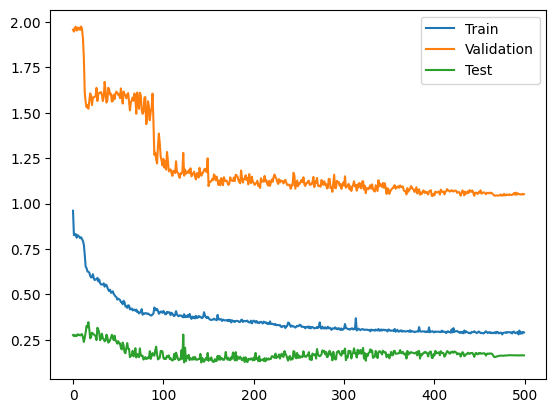

In [13]:
fig, ax = plt.subplots()

ax.plot(training.results['Train'], label='Train')
ax.plot(training.results['Validation'], label='Validation')
ax.plot(training.results['Test'], label='Test')
ax.legend()

## Evaluation and plotting classes

In [14]:
class OSAEvaluator:
    
    def evaluate_OSA(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            y_pred = model(src, tgt)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('********** OSA Evaluation summary **********')
        print(f'OSA MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'OSA RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'OSA R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
            
class FSEvaluator:
    
    def evaluate_FS(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        tgt_sim = None
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            if tgt_sim is None:
                tgt_sim = tgt
            else:
                tgt_sim[:-1,:] = tgt_sim[1:,:]
                tgt_sim[-1,:] = y_pred
            y_pred = model(src, tgt_sim)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('*********** FS Evaluation summary **********')
        print(f'FS MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'FS RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'FS R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
    
class Evaluator(OSAEvaluator, FSEvaluator):
    
    pass
        

In [15]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(test_dataset, model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(test_dataset, model)

100%|██████████| 699/699 [00:13<00:00, 52.50it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.1425158530473709
OSA RMSE: 0.37751272320747375
OSA R2 score: 0.5736635743246303
********************************************


100%|██████████| 699/699 [00:12<00:00, 57.59it/s]


*********** FS Evaluation summary **********
FS MSE: 0.40241849422454834
FS RMSE: 0.634364664554596
FS R2 score: -0.2038356723034933
********************************************


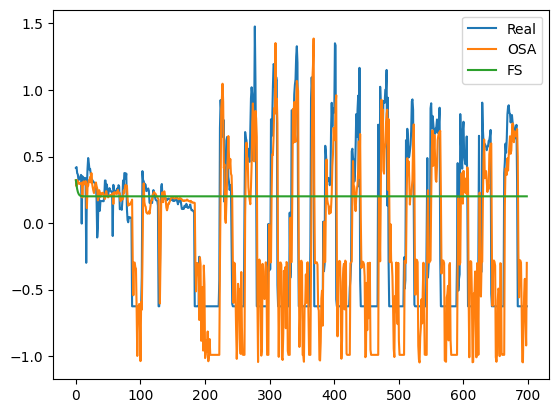

In [16]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()

In [17]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(test_dataset, best_model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(test_dataset, best_model)

100%|██████████| 699/699 [00:13<00:00, 52.23it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.11478743702173233
OSA RMSE: 0.33880293369293213
OSA R2 score: 0.6566131589260837
********************************************


100%|██████████| 699/699 [00:11<00:00, 58.54it/s]

*********** FS Evaluation summary **********
FS MSE: 0.39258500933647156
FS RMSE: 0.6265660524368286
FS R2 score: -0.1744188821042938
********************************************


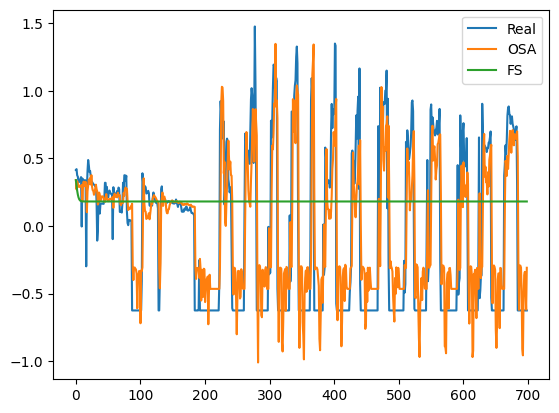

In [18]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()